In [25]:
#Part 1: 我们在此先生成了每个点的运动历史，即序列ηk，其中共4097个点，6000步历史，先固定alpha，随后再通过改变alpha的值检测其方差与
#t^(2H)

using StatsBase
using HypothesisTests
using Distributions

x_min = -2048                             #2048
x_max = 2048                              #2048
theta = 0                               # 质量幂次参数，我们依次取0，1/2，1，2，10，无穷
num_steps = 2000                          #分别考虑100，200……2000步，步差为100，
num_steps_history = 6000                  #ηk的长度
num_points = x_max - x_min + 1            #点的个数
#point_history = []                       #ηk的记录
alpha =  1/6                              #α的取值
H = alpha + 1/2                           #Hurst Coefficient

#我们先一次性取出10^8个随机数
A = rand(10^8)

# 优化：预分配Yita和History，避免push!
Yita = Vector{Vector{Float64}}(undef, num_points)
History = Vector{Vector{Int}}(undef, num_points)

# 定义函数g
function g(x)
    return (1 - x)^(-1 / alpha) - 1
end

# 优化：可选多线程并行（需Julia支持多线程）
Threads.@threads for i in 1:num_points
    choosed_random_numbers = A[(i-1)*num_steps_history + 1 : i*num_steps_history]
    Yita[i] = choosed_random_numbers

    Random_History = choosed_random_numbers
    history_each_point = Vector{Int}(undef, num_steps_history)
    for j in 1:num_steps_history
        x = Random_History[j]
        result = g(x)
        result = ceil(result)
        if result > num_steps_history
            index = -1
        else
            result = Int(result)
            index = j - result
        end
        if index <= 0
            random_walk = rand([-1, 1])
        else
            random_walk = history_each_point[index]
        end
        history_each_point[j] = random_walk
    end
    History[i] = history_each_point
end

#综上我们成功定义了所需要的ηk序列并且将其保存在了History数组中以便调用
#下面我们将考虑如何对点的随机游走进行处理


接下来是模拟程序的主体部分

In [20]:
#Part 2 ：对于每个点，先进行一定规则的随机游走，再判断点的运动状态以及吸收态，
B = rand(10^8)  # 生成一个包含10^8个随机数的数组
# 定义结构体
struct Point
    coords::Vector{Int}   # 点的坐标
    i::Int                # 点的索引，对点就行标号，判断点的吸收态
    j::Int                # 点被哪个点所吸收,点的吸收态
    k::Int                # 点的质量
    t::Int                # 0 为可以移动，1 为不能移动
    history::Vector{Int}  # 点的历史，存为一个数组
end

# 初始化所有点
function init_points(x_min, x_max, motion_history)
    points = [Point([2i, 0], i, i, 1, 0, motion_history[i - x_min + 1]) for i in x_min:x_max]
    return points
end

# 初始化轨迹
function init_trajectories(points, x_min)
    trajectories = [Vector{Vector{Int}}() for _ in points]
    for (index, point) in enumerate(points)
        idx = point.i - x_min + 1
        push!(trajectories[idx], point.coords)
    end
    return trajectories
end

# 构建可移动点的坐标字典
function build_coord_dict(points)
    coord_dict = Dict{Tuple{Int,Int}, Int}()
    for (idx, p) in enumerate(points)
        if p.t == 0
            coord_dict[(p.coords[1], p.coords[2])] = idx
        end
    end
    return coord_dict
end

# 生成本步所有可动点的随机数
function get_random_numbers(B, num_movable)
    random_numbers = splice!(B, 1:num_movable)
    return random_numbers
end

# 计算本步所有可动点的结果
function get_results(random_numbers, alpha)
    results = map(η -> (1 - η) ^ (-1 / alpha) - 1, random_numbers)
    results = ceil.(results)
    return results
end

# 添加级联更新j值的辅助函数
function cascade_update_j!(points, old_j, new_j)
    for (idx, p) in enumerate(points)
        if p.j == old_j
            points[idx] = Point(p.coords, p.i, new_j, p.k, p.t, p.history)
        end
    end
end

# 单步模拟
function simulate_step!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)
    coord_dict = build_coord_dict(points)
    movable_points = filter(p -> p.t == 0, points)
    num_movable = length(movable_points)
    random_numbers = get_random_numbers(B, num_movable)
    results = get_results(random_numbers, alpha)

    for (index, point) in enumerate(movable_points)
        coord_dict = build_coord_dict(points)
        global_idx = findfirst(p -> p.i == point.i, points)
        if points[global_idx].t == 1
            continue
        end
        if point.t == 0
            movable_index = findfirst(p -> p.i == point.i, movable_points)
            if  movable_index !== nothing
                result = results[movable_index]
                if  result > num_steps + num_steps_history
                    random_change = rand([-1, 1])
                else
                    result = Int(result)
                    if  length(point.history) - result <= 0
                        random_change = rand([-1, 1])
                    else
                        random_change = point.history[length(point.history) - result]
                    end
                end
            end

            new_history = copy(point.history)
            push!(new_history, random_change)
            new_coords = copy(point.coords)
            new_coords[1] += random_change
            new_coords[2] += 1
            
            new_point = Point(new_coords, point.i, point.j, point.k, 0, new_history)
            global_idx = findfirst(p -> p.i == point.i, points)
            points[global_idx] = new_point

            new_coord_tuple = (new_coords[1], new_coords[2])
            merged = false
            if  haskey(coord_dict, new_coord_tuple)
                target_idx = coord_dict[new_coord_tuple]
                if points[target_idx].i != point.i && points[target_idx].t == 0
                    m1 = new_point.k
                    m2 = points[target_idx].k
                    prob = m1^theta / (m1^theta + m2^theta)
                    
                    if  rand() < prob 
                        # global_idx wins - 级联更新所有被target吸收的点
                        old_j_target = points[target_idx].j
                        new_j_winner = points[global_idx].j
                        
                        # 更新获胜者的质量
                        points[global_idx] = Point(points[global_idx].coords, points[global_idx].i, points[global_idx].j, m1 + m2, 0, points[global_idx].history)
                        
                        # 级联更新所有j值等于old_j_target的点
                        cascade_update_j!(points, old_j_target, new_j_winner)
                        
                        # 设置被合并点为不可动
                        points[target_idx] = Point(points[target_idx].coords, points[target_idx].i, new_j_winner, points[target_idx].k, 1, points[target_idx].history)
                        merged = true
                    else                
                        # target_idx wins - 级联更新所有被global_idx吸收的点
                        old_j_global = points[global_idx].j
                        new_j_winner = points[target_idx].j
                        
                        # 更新获胜者的质量
                        points[target_idx] = Point(points[target_idx].coords, points[target_idx].i, points[target_idx].j, m1 + m2, 0, points[target_idx].history)
                        
                        # 级联更新所有j值等于old_j_global的点
                        cascade_update_j!(points, old_j_global, new_j_winner)
                        
                        # 设置被合并点为不可动
                        points[global_idx] = Point(points[global_idx].coords, points[global_idx].i, new_j_winner, points[global_idx].k, 1, points[global_idx].history)
                        merged = true
                    end
                    
                    # 合并后立即更新coord_dict，确保t值最新
                    coord_dict = build_coord_dict(points)
                    # 合并后也push最后一次坐标
                    idx = point.i - x_min + 1
                    push!(trajectories[idx], new_point.coords)
                    continue
                end
            end
            # 只要点还没被合并（t=0），就持续push
            if points[global_idx].t == 0 && !merged
                idx = point.i - x_min + 1
                push!(trajectories[idx], new_point.coords)
            end
        end
    end
end

simulate_step! (generic function with 1 method)

part3 is the way to generate the test statistics

In [22]:
#Part 3: 数据操作和统计分析
using Test
#以上完成了模拟，
#下面进行一定的数据操作
function analyze_step(trajectories, points, step, x_min)
    #for step in 100:100:num_steps
        # 统计每个点在step步时的横坐标和初始横坐标
        coord_map = Dict{Int, Tuple{Int, Int, Int}}()  # key: x坐标, value: (idx, t, origin)
        for (idx, traj) in enumerate(trajectories)
            if length(traj) >= step
                x = traj[step][1]
                origin = traj[1][1]
                tval = points[idx].t
                if haskey(coord_map, x)
                    # 若有重叠，保留t=0的，删除t=1的
                    old_idx, old_t, old_origin = coord_map[x]
                    if old_t == 1 && tval == 0
                    coord_map[x] = (idx, tval, origin)
                    elseif old_t == 0 && tval == 1
                        # reserve the original
                    elseif old_t == 0 && tval == 0
                        # 都可动，任选其一（默认保留原有）
                    elseif old_t == 1 && tval == 1
                        # 都不可动，任选其一（默认保留原有）
                    end
                else
                    coord_map[x] = (idx, tval, origin)
                end
            end
        end
    
    # 按照x_coords从小到大排序
    sorted_keys = sort(collect(keys(coord_map)))
    x_coords = sorted_keys
    origins = [coord_map[k][3] for k in sorted_keys]
    @assert length(x_coords) == length(origins) "Length mismatch: coords_diff and origins should be the same length"
    println("Step $step: x_coords = $x_coords")
    println("Step $step: origins = $origins")

    # 计算每个点的位移
    Displacement = [x_coords[i]- origins[i] for i in 1:length(x_coords)]
    println("Step $step: Displacement = $Displacement")
    @assert length(Displacement) == length(origins) "Length mismatch: Displacement and origins should be the same length"

    # 检验每个点的j值
    values_of_j = [points[coord_map[x][1]].j for x in sorted_keys]
    #println("Step $step: masses = $masses")
    @assert length(values_of_j) == length(origins) "Length mismatch: masses and origins should be the same length"

    # 计算吸收态相关的最大i值差距
    coords_diff = []
    for origin_index in origins
        k_idx = findfirst(x -> x.j == origin_index/2, points)
        m_idx = findlast(x -> x.j == origin_index/2, points)

        if k_idx !== nothing && m_idx !== nothing
            coord_diff = abs(points[k_idx].i - points[m_idx].i)
            push!(coords_diff, coord_diff)
        else
            # 如果没找到，设为0或跳过，视需求而定
            push!(coords_diff, 0)  # 或者 continue
        end
    end
    coords_difference = [coords_diff[i] for i in 2:length(coords_diff)-1]  # 考虑到边际效应，把最边上的两段去掉了
    println("Step $step: coords_difference = $coords_difference")
    #println(length(coords_diff))
    # 检查coords_diff和origins的长度是否一致
    #print( length(origins) == length( coords_diff)) 
    #print(length(origins) == length(coords_diff) ? "Lengths match" : "Lengths mismatch")

    # Nowwww we calculate the distance of x_coords
    x_coords_diff = [x_coords[i] - x_coords[i-1] for i in 3:length(x_coords)-1]   #考虑到边际效应，把最边上的两段去掉了
    println("Step $step: x_coords_diff = $x_coords_diff")
    #println(length(x_coords_diff) == length(coords_diff)-1)

end
#以上完成了对点的数据的输出

analyze_step (generic function with 1 method)

程序运行模块

In [26]:
# 主模拟函数
function run_simulation!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)
    for step in 1:num_steps
        simulate_step!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)
        if  step ∈ 100:100:num_steps      # 只在这些步输出
            analyze_step(trajectories, points, step, x_min)
            println()
        end
    end
end

# ========== 主流程调用 ===========
points = init_points(x_min, x_max, History)
trajectories = init_trajectories(points, x_min)
run_simulation!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)



Step 100: x_coords = [-4119, -4095, -4043, -4027, -4009, -3983, -3961, -3943, -3935, -3925, -3889, -3857, -3801, -3777, -3771, -3739, -3715, -3691, -3679, -3645, -3621, -3617, -3585, -3547, -3529, -3499, -3457, -3435, -3411, -3405, -3387, -3355, -3325, -3323, -3295, -3289, -3251, -3215, -3195, -3173, -3133, -3121, -3105, -3071, -3067, -3047, -3013, -2979, -2975, -2959, -2933, -2915, -2901, -2883, -2833, -2829, -2799, -2769, -2747, -2731, -2723, -2703, -2687, -2647, -2639, -2601, -2549, -2535, -2511, -2477, -2433, -2429, -2393, -2349, -2319, -2299, -2289, -2235, -2225, -2185, -2147, -2101, -2081, -2075, -2041, -2027, -2023, -1981, -1961, -1923, -1911, -1897, -1869, -1839, -1829, -1813, -1789, -1757, -1743, -1693, -1675, -1669, -1659, -1637, -1593, -1579, -1561, -1547, -1507, -1491, -1481, -1467, -1437, -1429, -1415, -1397, -1359, -1343, -1337, -1289, -1283, -1257, -1237, -1231, -1219, -1203, -1173, -1165, -1123, -1101, -1081, -1075, -1061, -1027, -987, -967, -943, -941, -917, -905, -901

以下是对于点的轨迹的可视化检测

In [ ]:
using Plots

function plot_trajectories(trajectories)
    p = plot()  # 创建一个新的图形
    # 只遍历前100个点的轨迹
    for i in 1:min(200, length(trajectories))
        traj = trajectories[i]
        if !isempty(traj)
            x_coords = [coord[1] for coord in traj]
            y_coords = [coord[2] for coord in traj]
            plot!(p, x_coords, y_coords, legend=false)
        end
    end
    display(p)  # 显示图形
end

# 假设trajectories是之前模拟生成的轨迹数组
plot_trajectories(trajectories)

在上面我们充分完成了一定的数据统计以及计算，接下来我们将进行一定的检测

we use the method of KS Test to examine the distribution 


In [ ]:
###project 2：在t=100,200,300……2000时,加入新的点
# Project 2：在t=100,200,300……2000时,加入新的点

# 第二个模型的主要函数
function add_new_points_at_step!(points, trajectories, step, x_min, x_max)
    """
    在指定步骤加入新点，横坐标和原先一样，纵坐标为当前步数
    """
    new_points_added = 0
    for i in x_min:x_max
        # 检查这个横坐标位置是否已经有点了
        existing_point_idx = findfirst(p -> p.coords[1] == 2*i && p.coords[2] == step, points)
        
        if existing_point_idx === nothing
            # 创建新点，使用已有的History
            new_point = Point([2*i, step], i, i, 1, 0, History[i - x_min + 1])
            push!(points, new_point)
            
            # 为新点创建轨迹，初始坐标就是当前位置
            push!(trajectories, Vector{Vector{Int}}())
            push!(trajectories[end], [2*i, step])
            
            new_points_added += 1
        end
    end
    
    return new_points_added
end

# 修改的模拟函数，支持在特定步骤加入新点
function run_simulation_with_new_points!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min, x_max)
    # 定义在哪些步骤加入新点
    add_points_steps = 100:100:num_steps
    
    for step in 1:num_steps
        # 在指定步骤加入新点
        if step in add_points_steps
            new_added = add_new_points_at_step!(points, trajectories, step, x_min, x_max)
            println("Step $step: 加入了 $new_added 个新点")
        end
        
        # 执行常规的模拟步骤
        simulate_step_model2!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)
        
        # 只在特定步输出分析
        if step ∈ 100:100:num_steps
            analyze_step_model2(trajectories, points, step, x_min)
            println()
        end
    end
end

# 修改的单步模拟函数，适应动态点数量
function simulate_step_model2!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)
    coord_dict = build_coord_dict(points)
    movable_points = filter(p -> p.t == 0, points)
    num_movable = length(movable_points)
    
    # 确保有足够的随机数
    if length(B) < num_movable
        append!(B, rand(num_movable - length(B)))
    end
    
    random_numbers = splice!(B, 1:num_movable)
    results = get_results(random_numbers, alpha)

    for (index, point) in enumerate(movable_points)
        coord_dict = build_coord_dict(points)
        global_idx = findfirst(p -> p.i == point.i && p.coords == point.coords, points)
        
        if global_idx === nothing || points[global_idx].t == 1
            continue
        end
        
        if point.t == 0
            movable_index = findfirst(p -> p.i == point.i && p.coords == point.coords, movable_points)
            if movable_index !== nothing
                result = results[movable_index]
                if result > num_steps + num_steps_history
                    random_change = rand([-1, 1])
                else
                    result = Int(result)
                    if length(point.history) - result <= 0
                        random_change = rand([-1, 1])
                    else
                        random_change = point.history[length(point.history) - result]
                    end
                end
            end

            new_history = copy(point.history)
            push!(new_history, random_change)
            new_coords = copy(point.coords)
            new_coords[1] += random_change
            new_coords[2] += 1
            
            new_point = Point(new_coords, point.i, point.j, point.k, 0, new_history)
            points[global_idx] = new_point

            # 找到对应的轨迹索引并更新
            traj_idx = findfirst(t -> !isempty(t) && t[1] == point.coords, trajectories)
            if traj_idx !== nothing && points[global_idx].t == 0
                push!(trajectories[traj_idx], new_coords)
            end
            
            # ...existing collision and merging logic...
            new_coord_tuple = (new_coords[1], new_coords[2])
            merged = false
            if haskey(coord_dict, new_coord_tuple)
                target_idx = coord_dict[new_coord_tuple]
                if points[target_idx].i != point.i && points[target_idx].t == 0
                    m1 = new_point.k
                    m2 = points[target_idx].k
                    prob = m1^theta / (m1^theta + m2^theta)
                    
                    if  rand() < prob 
                        # global_idx wins - 级联更新所有被target吸收的点
                        old_j_target = points[target_idx].j
                        new_j_winner = points[global_idx].j
                        
                        # 更新获胜者的质量
                        points[global_idx] = Point(points[global_idx].coords, points[global_idx].i, points[global_idx].j, m1 + m2, 0, points[global_idx].history)
                        
                        # 级联更新所有j值等于old_j_target的点
                        cascade_update_j!(points, old_j_target, new_j_winner)
                        
                        # 设置被合并点为不可动
                        points[target_idx] = Point(points[target_idx].coords, points[target_idx].i, new_j_winner, points[target_idx].k, 1, points[target_idx].history)
                        merged = true
                    else                
                        # target_idx wins - 级联更新所有被global_idx吸收的点
                        old_j_global = points[global_idx].j
                        new_j_winner = points[target_idx].j
                        
                        # 更新获胜者的质量
                        points[target_idx] = Point(points[target_idx].coords, points[target_idx].i, points[target_idx].j, m1 + m2, 0, points[target_idx].history)
                        
                        # 级联更新所有j值等于old_j_global的点
                        cascade_update_j!(points, old_j_global, new_j_winner)
                        
                        # 设置被合并点为不可动
                        points[global_idx] = Point(points[global_idx].coords, points[global_idx].i, new_j_winner, points[global_idx].k, 1, points[global_idx].history)
                        merged = true
                    end
                    
                    # 合并后立即更新coord_dict，确保t值最新
                    coord_dict = build_coord_dict(points)
                    # 合并后也push最后一次坐标
                    idx = point.i - x_min + 1
                    push!(trajectories[idx], new_point.coords)
                    continue
                end
            end
            # 只要点还没被合并（t=0），就持续push
            if points[global_idx].t == 0 && !merged
                idx = point.i - x_min + 1
                push!(trajectories[idx], new_point.coords)
            end
        end
    end
end

# 修改的分析函数
function analyze_step_model2(trajectories, points, step, x_min)
    active_points = filter(p -> p.t == 0, points)
    println("Step $step: 当前活跃点数量: $(length(active_points))")
    println("Step $step: 总点数量: $(length(points))")
    
    # 统计不同纵坐标的点的分布
    y_coords = [p.coords[2] for p in active_points]
    unique_y = unique(y_coords)
    
    println("Step $step: 不同纵坐标层的点数分布:")
    for y in sort(unique_y)
        count = sum(coord[2] == y for coord in y_coords)
        println("  y=$y: $count 个点")
    end
end

println("第二个模型函数定义完成！")
println("使用方法：")
println("1. 重新初始化: points2 = init_points(x_min, x_max, History)")
println("2. 重新初始化轨迹: trajectories2 = init_trajectories(points2, x_min)")
println("3. 运行第二个模型: run_simulation_with_new_points!(points2, trajectories2, rand(10^8), alpha, theta, num_steps, num_steps_history, x_min, x_max)")



检测是否符合分数阶布朗运动，先线性回归得出其t^(2H)的系数c，然后完成KS test对于onesample，Normal(0,c*t^(2H))

H value: 0.6666666666666666
Correlation between var(Displacement) and t^(2H): 0.9953361481006933
Linear regression results:
var(Displacement) = 0.67 * t^(2H) + -372.8431672860971
Coefficient c = 0.67
R-squared: 0.9906940477159252

=== 综合结论 ===
总共进行了 20 次KS检验
在α = 0.05水平下，100.0% 的检验不显著
✓ 强证据支持: displacement与正态分布同分布

KS Test Results Table:
20×4 DataFrame
 Row │ Step   P_Value  Statistic  Significant 
     │ Int64  Float64  Float64    String      
─────┼────────────────────────────────────────
   1 │   100   0.1296     0.0619  No
   2 │   200   0.2243     0.0716  No
   3 │   300   0.5159     0.0627  No
   4 │   400   0.2314     0.0862  No
   5 │   500   0.2361     0.0917  No
   6 │   600   0.4936     0.0793  No
   7 │   700   0.8475     0.0609  No
   8 │   800   0.8361     0.0643  No
   9 │   900   0.4334     0.0962  No
  10 │  1000   0.9979     0.0447  No
  11 │  1100   0.9855     0.0541  No
  12 │  1200   0.9047     0.0683  No
  13 │  1300   0.8227     0.0781  No
  14 │  1400   0.8105  

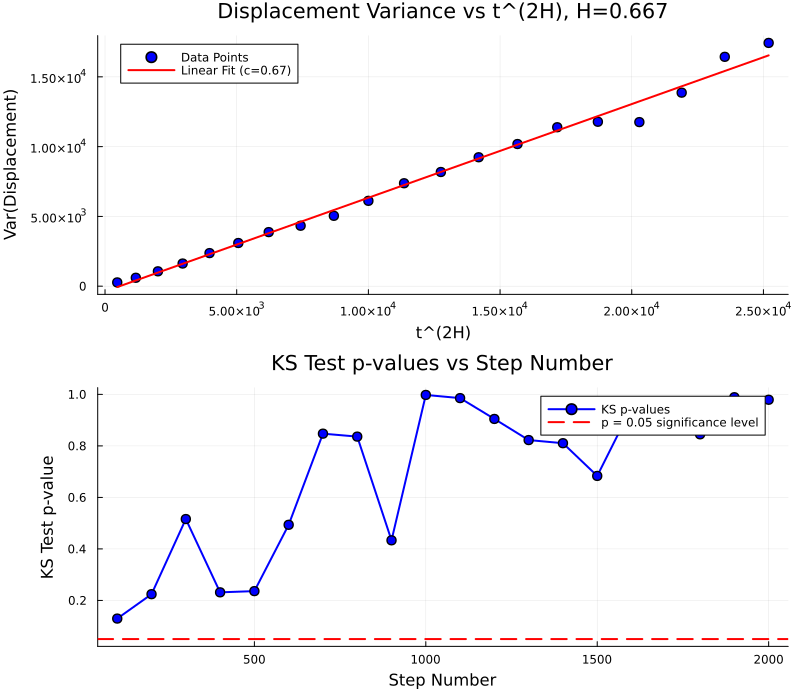

In [ ]:
# 统计每个step的Displacement方差，并与t^(2H)做比例性检测
using Statistics
using GLM
using DataFrames  
using HypothesisTests  
using Logging

# 暂时关闭警告
old_logger = global_logger(SimpleLogger(stderr, Logging.Error))

steps = 100:100:num_steps
vars = Float64[]
ts = Float64[]
all_displacements = Dict{Int, Vector{Float64}}()

for step in steps
    coord_map = Dict{Int, Tuple{Int, Int, Int}}()
    for (idx, traj) in enumerate(trajectories)
        if length(traj) >= step
            x = traj[step][1]
            origin = traj[1][1]
            tval = points[idx].t
            if haskey(coord_map, x)
                old_idx, old_t, old_origin = coord_map[x]
                if old_t == 1 && tval == 0
                    coord_map[x] = (idx, tval, origin)
                end
            else
                coord_map[x] = (idx, tval, origin)
            end
        end
    end
    sorted_keys = sort(collect(keys(coord_map)))
    x_coords = sorted_keys
    origins = [coord_map[k][3] for k in sorted_keys]
    Displacement = [x_coords[i] - origins[i] for i in 1:length(x_coords)]
    
    all_displacements[step] = copy(Displacement)
    
    if length(Displacement) > 1
        push!(vars, var(Displacement))
        push!(ts, step^(2*H))
    end
end

println("H value: ", H)

# 检查方差与t^(2H)的线性相关性
if length(vars) > 1 && length(ts) == length(vars)
    using StatsBase
    r = cor(ts, vars)
    println("Correlation between var(Displacement) and t^(2H): ", r)
    
    # 线性回归
    lm_model = lm(@formula(y ~ x), DataFrame(x=ts, y=vars))
    coef_ = coef(lm_model)
    c_coefficient = round(coef_[2], digits=2)
    intercept = coef_[1]
    
    println("Linear regression results:")
    println("var(Displacement) = ", c_coefficient, " * t^(2H) + ", intercept)
    println("Coefficient c = ", c_coefficient)
    println("R-squared: ", r2(lm_model))
    
    # KS检验
    ks_results = []
    for (i, step) in enumerate(steps)
        if haskey(all_displacements, step) && length(all_displacements[step]) > 1
            theoretical_var = c_coefficient * step^(2*H)
            theoretical_std = sqrt(theoretical_var)
            displacement_data = all_displacements[step]
            normal_dist = Normal(0, theoretical_std)
            ks_test = ApproximateOneSampleKSTest(displacement_data, normal_dist)
            p_value = pvalue(ks_test)
            statistic_value = ks_test.δ
            push!(ks_results, (step=step, p_value=p_value, statistic=statistic_value))
        end
    end
    
    global_logger(old_logger)
    
    # 只输出一次结果
    if length(ks_results) > 0
        p_values = [r.p_value for r in ks_results]
        non_significant_05 = sum(p_values .>= 0.05)
        proportion_ns = non_significant_05 / length(p_values)
        
        println("\n=== 综合结论 ===")
        println("总共进行了 $(length(p_values)) 次KS检验")
        println("在α = 0.05水平下，$(round(proportion_ns*100, digits=1))% 的检验不显著")
                
        ks_df = DataFrame(
            Step = [r.step for r in ks_results],
            P_Value = [round(r.p_value, digits=4) for r in ks_results],
            Statistic = [round(r.statistic, digits=4) for r in ks_results],
            Significant = [r.p_value < 0.05 ? "Yes" : "No" for r in ks_results]
        )
        
        println("\nKS Test Results Table:")
        println(ks_df)
    end
    
    # 绘图
    using Plots
    
    p1 = scatter(ts, vars, xlabel="t^(2H)", ylabel="Var(Displacement)", 
                label="Data Points", legend=:topleft, 
                title="Displacement Variance vs t^(2H), H=$(round(H, digits=3))",
                markersize=5, markercolor=:blue)
    plot!(p1, ts, predict(lm_model), label="Linear Fit (c=$c_coefficient)", 
          linewidth=2, linecolor=:red)
    
    if length(ks_results) > 0
        ks_steps = [r.step for r in ks_results]
        ks_pvalues = [r.p_value for r in ks_results]
        
        p2 = plot(ks_steps, ks_pvalues, 
                 xlabel="Step Number", ylabel="KS Test p-value", 
                 title="KS Test p-values vs Step Number",
                 linewidth=2, marker=:circle, markersize=5,
                 label="KS p-values", legend=:topright,
                 markercolor=:blue, linecolor=:blue)
        
        hline!(p2, [0.05], linestyle=:dash, linecolor=:red, 
               linewidth=2, label="p = 0.05 significance level")
        
        combined_plot = plot(p1, p2, layout=(2,1), size=(800, 700))
        display(combined_plot)
    else
        display(p1)
    end
    
else
    println("数据不足，无法进行相关性分析。")
end